# Quick `starry` tutorial
Here we'll discuss how to instantiate surface maps, plot them, rotate them, and compute phase curves and occultation light curves.

## Let's import `starry`...

In [1]:
import sys
sys.path.insert(1, "../")
from starry import starry

... and some other stuff, too.

In [2]:
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline

## The first order of business is to create a `starry` map.
A map is a vector of spherical harmonic coefficients, indexed by increasing order and degree:

$
y = 
        \{Y_{0,0}, \, 
        Y_{1,-1}, \, Y_{1,0}, \, Y_{1,1} \,
        Y_{2,-2}, \, Y_{2,-1}, \, Y_{2,0} \, Y_{2,1}, \, Y_{2,2}, \,
        ...
        \}
$

We create one by instantiating a `starry` object. The `starry` object takes a single argument, `lmax`, which is the highest order of the spherical harmonics used to describe the map. Let's keep things simple for now and create a 1st-order map:

In [3]:
s = starry(1)

Our map is currently a null map: 

In [4]:
print(s)

0.00e+00


The `starry` object is a souped-up subclass of `ndarray`, so we can edit the map directly by specifying the spherical harmonics we wish to add. Say we want our map to be very simple and equal to the spherical harmonic $Y_{1,-1}$. There are **three** ways of doing this:

#### 1. Specifying the *l* and *m* index of the spherical harmonic:

In [5]:
s[1,-1] = 1
print(s)

Y_{1,-1}


#### 2. Specifying the flattened index, $n = l^2 + l + m$, of the spherical harmonic:

In [6]:
s[1] = 1
print(s)

Y_{1,-1}


#### 3. Specifying all the map coefficients at once (useful if your map is composed of many Ylms):

In [7]:
s[:] = [0, 1, 0, 0]
print(s)

Y_{1,-1}


## Cool. Let's plot this map.

The map can be rendered using the `render` method:

In [8]:
s.render()

array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

Looks bad, but actually the `NaN`s correspond to portions of the map that are off the planet surface (we are, after all, trying to represent a circle as a matrix). We could use `imshow` to plot this map, but `starry` can also do that for us via the `show` method:

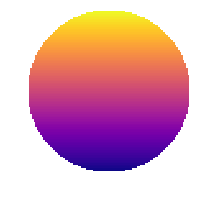

In [9]:
s.show()

As you can verify on [Wikipedia](https://en.wikipedia.org/wiki/Table_of_spherical_harmonics#Real_spherical_harmonics), the spherical harmonic $Y_{1,-1}$ in Cartesian coordinates is simply some constant times $y$, which is what we are seeing here: a uniform gradient from negative flux at the south pole to positive flux at the north pole of the body.

## Let's apply some rotations.
One thing that `starry` allows us to do easily is rotate the base map. As an example, let's rotate the map 90 degrees about the *z*-axis:

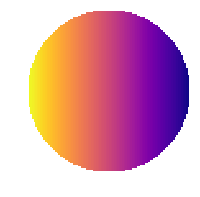

In [10]:
s.rotate(u=[0, 0, 1], theta=np.pi/2)
s.show()

As you can probably guess, the `u` argument is a unit vector corresponding to the axis of rotation, which in this example we set to the *z* axis. The `theta` argument is the angle of rotation in radians, measured counter-clockwise as we stare down the axis of rotation. If we print the `starry` instance, we notice that the base map has changed:

In [11]:
print(s)

-Y_{1,1}


One of the many cool things about spherical harmonics is that rotation of a $Y_{lm}$ in 3D space about any axis results in a linear combination of $Y_{lm'}$s of the same order $l$. In this case, the rotation transformed the map to  (negative) $Y_{1,1}$, which is just [proportional to (negative) $x$](https://en.wikipedia.org/wiki/Table_of_spherical_harmonics#Real_spherical_harmonics).

Let's apply another 90-degree rotation to the map, this time about the $y$-axis:

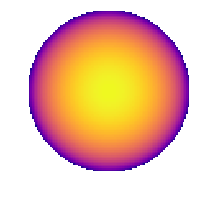

In [12]:
s.rotate(u=[0, 1, 0], theta=np.pi/2)
s.show()

In [13]:
print(s)

Y_{1,0}


Our map is now the spherical harmonic $Y_{1,0}$, which is [proportional to $z$](https://en.wikipedia.org/wiki/Table_of_spherical_harmonics#Real_spherical_harmonics). Finally, let's apply one final rotation about the $x$ axis to return our map to the original orientation:

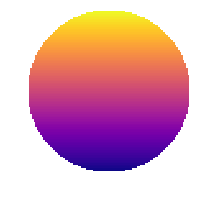

In [14]:
s.rotate(u=[1, 0, 0], theta=-np.pi/2)
s.show()

In [15]:
print(s)

Y_{1,-1}


## Ok, let's compute some phase curves.
What we really would like to do is compute light curves. So let's get to it. Everything you need is in the `flux` method:

    def flux(self, u=[0, 1, 0], theta=0, x0=None, y0=None, r=None, debug=False, res=100):
        """Return the flux visible from the map."""
        ...

As before, the `u` and `theta` parameters define the orientation of the map. The parameters `x0`, `y0`, and `r` define the location and size of the occulting body (if any) relative to the `starry` object. `x0` and `y0` are the location of the center of the occultor and `r` is its radius, all measured in units of the `starry` object's radius (=1). By the way, `theta`, `x0`, `y0`, and `r0` can all be either scalars or vectors. If more than one is a vector, their sizes must (obviously) match.

The `debug` argument, if set to `True`, computes the flux numerically by gridding up the planet (with spatial resolution equal to `res`). It is therefore extremely slow, but good for debugging!

To start, let's simply compute some phase curves, with no occultations. We will vary `theta` between 0 and 2`pi`. Let's create two `theta` grids: a fine one, for the analytic calculations, and a coarse one, for the numerical calculations, so we can compare the results.

In [21]:
theta = np.linspace(0, 2 * np.pi, 100, endpoint=False)
theta_debug = np.linspace(0, 2 * np.pi, 10, endpoint=False)

Let's rotate our map about the $x$-axis:

In [37]:
F = s.flux(u=[1, 0, 0], theta=theta)

Let's do the same calculation numerically:

In [38]:
F_debug = s.flux(u=[1, 0, 0], theta=theta_debug, debug=True)

Compare the results:

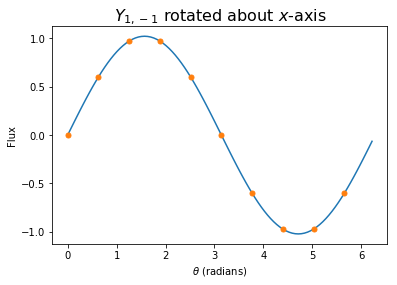

In [39]:
fig, ax = pl.subplots(1)
ax.plot(theta, F);
ax.plot(theta_debug, F_debug, '.', ms=10);
ax.set_xlabel(r'$\theta$ (radians)');
ax.set_ylabel(r'Flux');
ax.set_title(r'$' + str(s) + r'$ rotated about $x$-axis', fontsize=16);

Rotation of $Y_{-1,1}$ about either the $y$ axis or the $z$ axis results in no phase variation because of its symmetry. So let's look at a higher order spherical harmonic just for fun:

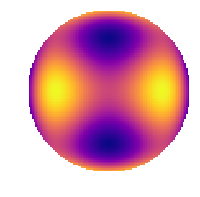

Y_{4,2}


In [62]:
s = starry(4)
s[4, 2] = 1
s.show()
print(s)

Let's rotate it about all three principal axes and look at its phase curves.

In [63]:
Fx = s.flux(u=[1, 0, 0], theta=theta)
Fy = s.flux(u=[0, 1, 0], theta=theta)
Fz = s.flux(u=[0, 0, 1], theta=theta)

In [64]:
Fx_debug = s.flux(u=[1, 0, 0], theta=theta_debug, debug=True)
Fy_debug = s.flux(u=[0, 1, 0], theta=theta_debug, debug=True)
Fz_debug = s.flux(u=[0, 0, 1], theta=theta_debug, debug=True)

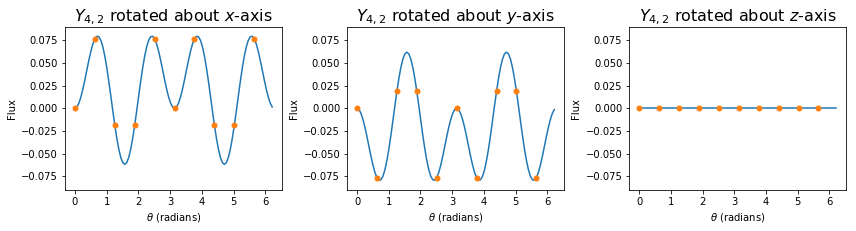

In [66]:
fig, ax = pl.subplots(1,3, figsize=(14,3))
fig.subplots_adjust(wspace=0.3)
axis = ['x', 'y', 'z']
for i, F, F_debug in zip(range(3), [Fx, Fy, Fz], [Fx_debug, Fy_debug, Fz_debug]):
    ax[i].plot(theta, F);
    ax[i].plot(theta_debug, F_debug, '.', ms=10);
    ax[i].set_xlabel(r'$\theta$ (radians)');
    ax[i].set_ylabel(r'Flux');
    ax[i].set_title(r'$' + str(s) + r'$ rotated about $%s$-axis' % axis[i], fontsize=16);
    ax[i].set_ylim(-0.09,0.09)

## What about occultations?
These are just as easy!

Let's start with the following map:

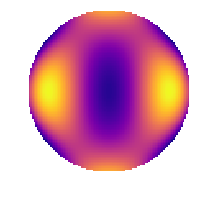

Y_{0,0} - 5.00e-01 Y_{4,0} + 5.00e-01 Y_{4,2} + 5.00e-01 Y_{4,4}


In [89]:
s = starry(4)
s[0, 0] = 1
s[4, 0] = -0.5
s[4, 2] = 0.5
s[4, 4] = 0.5
s.show()
print(s)

Consider an occultor of radius 0.1 moving along the $+x$ direction at $y_0 = 0.5$. Suppose that the occulted body rotates by an angle $\pi/8$ about the $y$-axis in the meantime. Computing the light curve is easy:

In [97]:
npts = 100
r = 0.1
x0 = np.linspace(-3,3, npts)
y0 = 0.5
u = [0, 1, 0]
theta = np.linspace(0, np.pi / 8, npts, endpoint=False)
F = s.flux(u=u, theta=theta, x0=x0, y0=y0, r=r)

As before, let's compute the flux numerically as a check:

In [101]:
theta_debug = np.linspace(0, np.pi / 8, 50, endpoint=False)
x0_debug = np.linspace(-3, 3, 50)
F_debug = s.flux(u=u, theta=theta_debug, x0=x0_debug, y0=y0, r=r, debug=True, res=100)

Here's the light curve:

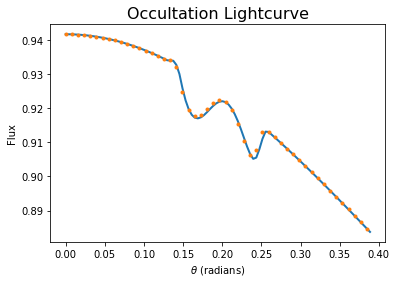

In [106]:
fig, ax = pl.subplots(1)
ax.plot(theta, F, lw=2);
ax.plot(theta_debug, F_debug, '.', ms=6);
ax.set_xlabel(r'$\theta$ (radians)');
ax.set_ylabel(r'Flux');
ax.set_title(r'Occultation Lightcurve', fontsize=16);